In [1]:
## Load packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from scipy import stats
import bisect
import warnings
warnings.filterwarnings('ignore')

from xgboost.sklearn import XGBRegressor
from sklearn import model_selection, preprocessing
import xgboost as xgb

%matplotlib inline

In [2]:
#timestamp:from object to datetime64[ns]
train_df = pd.read_csv('train.csv', parse_dates=['timestamp'])
test_df = pd.read_csv('test.csv', parse_dates=['timestamp'])
macro_df = pd.read_csv('macro.csv', parse_dates=['timestamp'])

In [3]:
print(train_df.columns)
print(train_df.shape)
print(test_df.shape)

Index(['id', 'timestamp', 'full_sq', 'life_sq', 'floor', 'max_floor',
       'material', 'build_year', 'num_room', 'kitch_sq',
       ...
       'cafe_count_5000_price_2500', 'cafe_count_5000_price_4000',
       'cafe_count_5000_price_high', 'big_church_count_5000',
       'church_count_5000', 'mosque_count_5000', 'leisure_count_5000',
       'sport_count_5000', 'market_count_5000', 'price_doc'],
      dtype='object', length=292)
(30471, 292)
(7662, 291)


In [4]:
train_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


count    3.047100e+04
mean     7.123035e+06
std      4.780111e+06
min      1.000000e+05
25%      4.740002e+06
50%      6.274411e+06
75%      8.300000e+06
max      1.111111e+08
Name: price_doc, dtype: float64


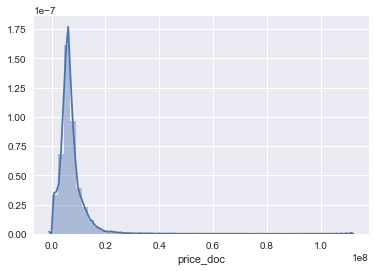

In [5]:
## Describe the output field
print(train_df['price_doc'].describe())
sns.distplot(train_df['price_doc'])

count    30471.000000
mean        15.609483
std          0.604574
min         11.512935
25%         15.371548
50%         15.651990
75%         15.931766
max         18.526041
Name: LogAmt, dtype: float64


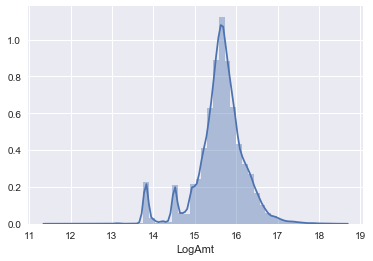

In [6]:
#new col:LogAmt 取log將極端值拉回
train_df['LogAmt']=np.log(train_df.price_doc+1.0)
print(train_df['LogAmt'].describe())
sns.distplot(train_df['LogAmt'])

In [7]:
#new col:Source 將test和train合併一起整理
train_cp = train_df.copy()
train_cp['Source']='Train'
test_cp = test_df.copy()
test_cp['Source']='Test'
alldata = pd.concat([train_cp, test_cp],ignore_index=True)

In [8]:
alldata.shape

(38133, 294)

In [9]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38133 entries, 0 to 38132
Columns: 294 entries, 0_13_all to zd_vokzaly_avto_km
dtypes: datetime64[ns](1), float64(122), int64(155), object(16)
memory usage: 85.5+ MB


In [10]:
alldata.columns

Index(['0_13_all', '0_13_female', '0_13_male', '0_17_all', '0_17_female',
       '0_17_male', '0_6_all', '0_6_female', '0_6_male', '16_29_all',
       ...
       'water_km', 'water_treatment_km', 'work_all', 'work_female',
       'work_male', 'workplaces_km', 'young_all', 'young_female', 'young_male',
       'zd_vokzaly_avto_km'],
      dtype='object', length=294)

In [11]:
macro_df.columns 

Index(['timestamp', 'oil_urals', 'gdp_quart', 'gdp_quart_growth', 'cpi', 'ppi',
       'gdp_deflator', 'balance_trade', 'balance_trade_growth', 'usdrub',
       'eurrub', 'brent', 'net_capital_export', 'gdp_annual',
       'gdp_annual_growth', 'average_provision_of_build_contract',
       'average_provision_of_build_contract_moscow', 'rts', 'micex',
       'micex_rgbi_tr', 'micex_cbi_tr', 'deposits_value', 'deposits_growth',
       'deposits_rate', 'mortgage_value', 'mortgage_growth', 'mortgage_rate',
       'grp', 'grp_growth', 'income_per_cap',
       'real_dispos_income_per_cap_growth', 'salary', 'salary_growth',
       'fixed_basket', 'retail_trade_turnover',
       'retail_trade_turnover_per_cap', 'retail_trade_turnover_growth',
       'labor_force', 'unemployment', 'employment',
       'invest_fixed_capital_per_cap', 'invest_fixed_assets',
       'profitable_enterpr_share', 'unprofitable_enterpr_share',
       'share_own_revenues', 'overdue_wages_per_cap', 'fin_res_per_cap',
    

In [12]:
#將macro.csv的col重新塑名之後置放同一群組
macro_df.columns = ['mac__'+c if c!='timestamp' else 'timestamp' for c in macro_df.columns ]
#macro_df.columns

In [13]:
#將alldata與macro進行merge by timestamp
alldata=alldata.merge(macro_df,on='timestamp',how='left')
alldata.shape
#alldata.columns

(38133, 393)

In [14]:
#for var_desc 觀看object類型的col
alldata_dtype=alldata.dtypes
display_nvar = len(alldata.columns)
#display_nvar

In [15]:
alldata_dtype_dict = alldata_dtype.to_dict()
alldata.dtypes.value_counts()

float64           216
int64             157
object             19
datetime64[ns]      1
dtype: int64

In [16]:
def var_desc(dt,alldata):
    print('--------------------------------------------')
    for c in alldata.columns:
        if alldata[c].dtype==dt:
            t1 = alldata[alldata.Source=='Train'][c]
            t2 = alldata[alldata.Source=='Test'][c]
            if dt=="object":
                f1 = t1[pd.isnull(t1)==False].value_counts()
                f2 = t2[pd.isnull(t2)==False].value_counts()
            else:
                f1 = t1[pd.isnull(t1)==False].describe()
                f2 = t2[pd.isnull(t2)==False].describe()
            m1 = t1.isnull().value_counts()
            m2 = t2.isnull().value_counts()
            f = pd.concat([f1, f2], axis=1)
            m = pd.concat([m1, m2], axis=1)
            f.columns=['Train','Test']
            m.columns=['Train','Test']
            print(dt+' - '+c)
            print('UniqValue - ',len(t1.value_counts()),len(t2.value_counts()))
            print(f.sort_values(by='Train',ascending=False))
            print()

            m_print=m[m.index==True]
            if len(m_print)>0:
                print('missing - '+c)
                print(m_print)
            else:
                print('NO Missing values - '+c)
            if dt!="object":
                if len(t1.value_counts())<=10:
                    c1 = t1.value_counts()
                    c2 = t2.value_counts()
                    c = pd.concat([c1, c2], axis=1)
                    f.columns=['Train','Test']
                    print(c)
            print('--------------------------------------------')

In [17]:
#var_desc('object',alldata)

--------------------------------------------
object - Source
UniqValue -  1 1
         Train    Test
Train  30471.0     NaN
Test       NaN  7662.0

NO Missing values - Source
--------------------------------------------
object - big_market_raion
UniqValue -  2 2
     Train  Test
no   27649  7130
yes   2822   532

NO Missing values - big_market_raion
--------------------------------------------
object - big_road1_1line
UniqValue -  2 2
     Train  Test
no   29690  7339
yes    781   323

NO Missing values - big_road1_1line
--------------------------------------------
object - culture_objects_top_25
UniqValue -  2 2
     Train  Test
no   28543  6971
yes   1928   691

NO Missing values - culture_objects_top_25
--------------------------------------------
object - detention_facility_raion
UniqValue -  2 2
     Train  Test
no   27427  6876
yes   3044   786

NO Missing values - detention_facility_raion
--------------------------------------------
object - ecology
UniqValue -  5 5
            

In [18]:
#excl_col建立例外資料
# excl_col=['id','timestamp','sub_area'] + [c for c in alldata.columns if alldata[c].dtype=='object']
# excl_col

['id',
 'timestamp',
 'sub_area',
 'Source',
 'big_market_raion',
 'big_road1_1line',
 'culture_objects_top_25',
 'detention_facility_raion',
 'ecology',
 'incineration_raion',
 'nuclear_reactor_raion',
 'oil_chemistry_raion',
 'product_type',
 'radiation_raion',
 'railroad_1line',
 'railroad_terminal_raion',
 'sub_area',
 'thermal_power_plant_raion',
 'water_1line',
 'mac__child_on_acc_pre_school',
 'mac__modern_education_share',
 'mac__old_education_build_share']

In [21]:
#find -1 表示沒有存在這個字串
# x = 'fox_test'
# x.find('fire')

-1

In [22]:
#null_num = alldata.isnull().sum()
#null_num.to_csv('alldata_nullnum.csv')

In [18]:
#cols type from object to int
for f in alldata.columns:
    if f not in ['timestamp','Source']:
        if alldata[f].dtype=='object':
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(alldata[f].values)) 
            alldata[f] = lbl.transform(list(alldata[f].values))

In [19]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38133 entries, 0 to 38132
Columns: 393 entries, 0_13_all to mac__apartment_fund_sqm
dtypes: datetime64[ns](1), float64(216), int64(175), object(1)
memory usage: 114.6+ MB


In [20]:
#resv_col也是例外col,NA太多的
excl_col=['id','timestamp'] + [c for c in alldata.columns if alldata[c].dtype=='object']
resv_col=['price_doc','LogAmt','Source','cafe_sum_500_max_price_avg','cafe_sum_500_min_price_avg',
          'cafe_avg_price_500','hospital_beds_raion']
excl_col

['id', 'timestamp', 'Source']

In [21]:
def sel_grp(keys):
    lst_all = list()
    for k in keys:
        lst = [c for c in alldata.columns if c.find(k)!=-1 and c not in excl_col and c not in resv_col]
        lst = list(set(lst))
        lst_all += lst
    return(lst_all)

In [23]:
col_grp = dict({})
col_grp['people']=sel_grp(['_all','male'])
col_grp['id'] = sel_grp(['ID_'])
col_grp['church']=sel_grp(['church'])
col_grp['build']=sel_grp(['build_count_'])
col_grp['cafe']=sel_grp(['cafe_count'])
col_grp['cafeprice']=sel_grp(['cafe_sum','cafe_avg'])
col_grp['km']=sel_grp(['_km','metro_min','_avto_min','_walk_min','_min_walk'])
col_grp['mosque']=sel_grp(['mosque_count'])
col_grp['market']=sel_grp(['market_count'])
col_grp['office']=sel_grp(['office_count'])
col_grp['leisure']=sel_grp(['leisure_count'])
col_grp['sport']=sel_grp(['sport_count'])
col_grp['green']=sel_grp(['green_part'])
col_grp['prom']=sel_grp(['prom_part'])
col_grp['trc']=sel_grp(['trc_count'])
col_grp['sqm']=sel_grp(['_sqm_'])
col_grp['raion']=sel_grp(['_raion'])
col_grp['macro']=sel_grp(['mac__'])
col_grp.keys()

dict_keys(['people', 'id', 'church', 'build', 'cafe', 'cafeprice', 'km', 'mosque', 'market', 'office', 'leisure', 'sport', 'green', 'prom', 'trc', 'sqm', 'raion', 'macro'])

In [24]:
col_grp['people']

['0_6_all',
 'full_all',
 '7_14_all',
 'ekder_all',
 '16_29_all',
 'work_all',
 'young_all',
 '0_17_all',
 '0_13_all',
 'male_f',
 '0_13_female',
 'young_male',
 '0_6_female',
 'ekder_male',
 'ekder_female',
 'female_f',
 '16_29_female',
 '16_29_male',
 '0_17_female',
 'work_male',
 '7_14_male',
 'work_female',
 '0_17_male',
 '0_6_male',
 'young_female',
 '0_13_male',
 '7_14_female']

In [25]:
col_tmp = list()
for d in col_grp:
    col_tmp+=(col_grp[d])
col_grp['other']=[c for c in alldata.columns if c not in col_tmp and c not in excl_col and c not in resv_col]
col_grp['other'] 

['area_m',
 'big_road1_1line',
 'build_year',
 'children_preschool',
 'children_school',
 'culture_objects_top_25',
 'ecology',
 'floor',
 'full_sq',
 'green_zone_part',
 'indust_part',
 'kitch_sq',
 'life_sq',
 'material',
 'max_floor',
 'num_room',
 'preschool_quota',
 'product_type',
 'railroad_1line',
 'raion_popul',
 'school_quota',
 'state',
 'sub_area',
 'water_1line']

In [26]:
#將na太多的macro_col找出然後也列入excl_col,再重新建立一次macro_pca群組
macro_missing_2 = pd.DataFrame([[c,sum(alldata[c].isnull())] for c in col_grp['macro']],columns=['Var','Missing'])
macro_missing_3=macro_missing_2[macro_missing_2.Missing>5000]
print(macro_missing_3)
excl_col+=list(macro_missing_3.Var)
print(excl_col)

col_grp['macro']=sel_grp(['mac__'])

                                            Var  Missing
2                        mac__provision_doctors    10901
4                           mac__sewerage_share    10901
7                 mac__invest_fixed_assets_phys    10901
10                           mac__heating_share    10901
13                       mac__water_pipes_share    10901
15         mac__hospital_beds_available_per_cap    10901
21                            mac__divorce_rate    10901
22                              mac__grp_growth    10901
24                                     mac__grp    10901
25           mac__theaters_viewers_per_1000_cap    24563
27                           mac__pop_total_inc    10901
33              mac__provision_retail_space_sqm    32541
34                             mac__baths_share    10901
36  mac__load_of_teachers_preschool_per_teacher    24563
38              mac__museum_visitis_per_100_cap    24563
39       mac__provision_retail_space_modern_sqm    37380
40                      mac__co

In [27]:
loopkeys=list(col_grp.keys())
print(loopkeys)

['people', 'id', 'church', 'build', 'cafe', 'cafeprice', 'km', 'mosque', 'market', 'office', 'leisure', 'sport', 'green', 'prom', 'trc', 'sqm', 'raion', 'macro', 'other']


In [49]:
#以id群組當範例
test123 = alldata[col_grp['people']]
test123

,0_6_all,full_all,7_14_all,ekder_all,16_29_all,work_all,young_all,0_17_all,0_13_all,male_f,...,16_29_male,0_17_female,work_male,7_14_male,work_female,0_17_male,0_6_male,young_female,0_13_male,7_14_female
0,9576,86206,10309,36211,17508,98207,21154,23603,18654,40477,...,9425,11317,52277,5463,45930,12286,4899,10147,9709,4846
1,6880,76284,7759,29431,15164,70194,15727,17700,13729,34200,...,7571,8702,35622,3909,34572,8998,3466,7802,6929,3850
2,5879,101982,6207,25292,19401,63388,13028,14884,11252,46076,...,9045,7063,31813,3269,31575,7821,3095,6193,5916,2938
3,13087,21155,13670,29529,3292,120381,28563,32063,24934,9828,...,1450,15550,60040,7126,60341,16513,6645,13883,12782,6544
4,5706,28179,6748,26760,5164,68043,13368,15237,11631,13522,...,2583,7124,34236,3664,33807,8113,2982,6209,6223,3084
5,2418,19940,2514,8844,4851,29660,5291,5866,4632,9400,...,2329,2831,15793,1328,13867,3035,1224,2547,2399,1186
6,2459,85956,2810,16720,19445,35003,5682,6510,4884,40724,...,10085,3165,17490,1472,17513,3345,1241,2757,2507,1338
7,9576,86206,10309,36211,17508,98207,21154,23603,18654,40477,...,9425,11317,52277,5463,45930,12286,4899,10147,9709,4846
8,6507,78810,6566,23938,17662,59120,13901,15510,12269,36091,...,8488,7309,29664,3453,29456,8201,3456,6557,6487,3113
9,9347,78507,9292,37127,15929,85551,19784,22071,17469,37052,...,8541,10587,43352,4919,42199,11484,4806,9445,9082,4373


In [50]:
#將有na的row拿掉
print(test123.shape)
print(len(test123))
test123na = test123.dropna()
print(len(test123na))

(38133, 27)
38133
38133


In [51]:
#正規化
test123na = (test123na-test123na.mean())/test123na.std(ddof=0)

In [52]:
test123na

,0_6_all,full_all,7_14_all,ekder_all,16_29_all,work_all,young_all,0_17_all,0_13_all,male_f,...,16_29_male,0_17_female,work_male,7_14_male,work_female,0_17_male,0_6_male,young_female,0_13_male,7_14_female
0,1.153571,-0.206840,1.235403,1.286143,-0.223144,1.182149,1.196120,1.188467,1.201285,-0.201041,...,-0.197245,1.149805,1.315599,1.317926,1.040220,1.222768,1.141788,1.158690,1.235537,1.143937
1,0.445573,-0.242215,0.593991,0.768454,-0.262330,0.431091,0.539309,0.548430,0.523683,-0.249963,...,-0.261107,0.565753,0.431795,0.558938,0.428044,0.531123,0.413604,0.573713,0.494024,0.629071
2,0.182700,-0.150592,0.203610,0.452419,-0.191497,0.248615,0.212659,0.243104,0.182887,-0.157403,...,-0.210335,0.199688,0.229669,0.246356,0.266511,0.283535,0.225079,0.172336,0.223825,0.157627
3,2.075597,-0.438771,2.080810,0.775937,-0.460802,1.776658,2.092805,2.105747,2.065314,-0.439917,...,-0.471947,2.095231,1.727545,2.130151,1.816947,2.111937,2.029025,2.090663,2.055203,2.021691
4,0.137269,-0.413728,0.339690,0.564509,-0.429507,0.373420,0.253808,0.281378,0.235031,-0.411126,...,-0.432921,0.213312,0.358246,0.439277,0.386812,0.344959,0.167657,0.176327,0.305712,0.233100
5,-0.726195,-0.443103,-0.725306,-0.803474,-0.434740,-0.655669,-0.723723,-0.734679,-0.727920,-0.443253,...,-0.441670,-0.745514,-0.620439,-0.701647,-0.687919,-0.723221,-0.725678,-0.737186,-0.714269,-0.748041
6,-0.715428,-0.207731,-0.650852,-0.202099,-0.190762,-0.512418,-0.676402,-0.664853,-0.693249,-0.199116,...,-0.174511,-0.670917,-0.530387,-0.631316,-0.491406,-0.658011,-0.717039,-0.684800,-0.685462,-0.669467
7,1.153571,-0.206840,1.235403,1.286143,-0.223144,1.182149,1.196120,1.188467,1.201285,-0.201041,...,-0.197245,1.149805,1.315599,1.317926,1.040220,1.222768,1.141788,1.158690,1.235537,1.143937
8,0.347620,-0.233209,0.293910,0.349034,-0.220569,0.134185,0.318315,0.310978,0.322810,-0.235225,...,-0.229521,0.254632,0.115631,0.336223,0.152301,0.363470,0.408522,0.263138,0.376129,0.248091
9,1.093434,-0.234289,0.979593,1.356085,-0.249541,0.842828,1.030314,1.022359,1.038248,-0.227735,...,-0.227695,0.986762,0.841990,1.052231,0.839126,1.054064,1.094530,0.983571,1.068297,0.899428


In [53]:
pca = PCA()
pca.fit(test123na)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [54]:
#explained_variance_ratio_ : array, [n_components] Percentage of variance explained by each of the selected components.
varexp = pca.explained_variance_ratio_
varexp

array([  7.53582213e-01,   2.12758562e-01,   2.66880451e-02,
         3.85423076e-03,   1.47829168e-03,   6.98226253e-04,
         3.44258697e-04,   3.24058672e-04,   8.43105715e-05,
         6.46158272e-05,   6.00875755e-05,   4.45532416e-05,
         7.00054657e-06,   4.85994869e-06,   4.36777849e-06,
         1.07115559e-06,   8.78929746e-07,   3.67153621e-07,
         1.82437187e-10,   9.36703257e-11,   2.48914220e-11,
         5.11605895e-12,   3.93370816e-12,   1.83827039e-12,
         1.75201882e-13,   2.05897850e-14,   2.93255081e-15])

In [55]:
#numpy.cumsum(a, axis=None, dtype=None, out=None) Return the cumulative sum of the elements along a given axis.
varexp = pca.explained_variance_ratio_.cumsum()
varexp

array([ 0.75358221,  0.96634078,  0.99302882,  0.99688305,  0.99836134,
        0.99905957,  0.99940383,  0.99972789,  0.9998122 ,  0.99987681,
        0.9999369 ,  0.99998145,  0.99998845,  0.99999331,  0.99999768,
        0.99999875,  0.99999963,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ])

In [56]:
#取總和解釋力95%的所有col,另種方式是在PCA時先指定要降成多少維度
cutoff = bisect.bisect(varexp, 0.95)
cutoff

1

In [57]:
newcol=pd.DataFrame(pca.fit_transform(X=test123na)[:,0:(cutoff+1)],
                    columns=['PCA_'+'id'+'_'+str(i) for i in range(cutoff+1)],index=test123na.index)
newcol

,PCA_id_0,PCA_id_1
0,5.372580,-1.262548
1,2.404877,-0.924543
2,1.042389,-0.537072
3,8.309040,-2.411457
4,1.262252,-1.169630
5,-3.446276,-0.614439
6,-2.746836,-0.049599
7,5.372580,-1.262548
8,1.254451,-0.735516
9,4.657567,-1.205872


In [62]:
month_year = (alldata.timestamp.dt.month + alldata.timestamp.dt.year * 100)
month_year

0        201108
1        201108
2        201108
3        201109
4        201109
5        201109
6        201109
7        201109
8        201109
9        201109
10       201109
11       201109
12       201109
13       201109
14       201109
15       201109
16       201109
17       201109
18       201109
19       201109
20       201109
21       201109
22       201109
23       201109
24       201109
25       201109
26       201109
27       201109
28       201109
29       201109
          ...  
38103    201605
38104    201605
38105    201605
38106    201605
38107    201605
38108    201605
38109    201605
38110    201605
38111    201605
38112    201605
38113    201605
38114    201605
38115    201605
38116    201605
38117    201605
38118    201605
38119    201605
38120    201605
38121    201605
38122    201605
38123    201605
38124    201605
38125    201605
38126    201605
38127    201605
38128    201605
38129    201605
38130    201605
38131    201605
38132    201605
Name: timestamp, dtype: 

In [59]:
month_year_cnt_map = month_year.value_counts().to_dict()
month_year_cnt_map

{201108: 3,
 201109: 39,
 201110: 213,
 201111: 259,
 201112: 239,
 201201: 257,
 201202: 364,
 201203: 380,
 201204: 300,
 201205: 297,
 201206: 359,
 201207: 391,
 201208: 336,
 201209: 545,
 201210: 509,
 201211: 549,
 201212: 552,
 201301: 264,
 201302: 277,
 201303: 772,
 201304: 839,
 201305: 532,
 201306: 520,
 201307: 757,
 201308: 661,
 201309: 643,
 201310: 893,
 201311: 916,
 201312: 904,
 201401: 868,
 201402: 1143,
 201403: 1203,
 201404: 1296,
 201405: 1125,
 201406: 1278,
 201407: 727,
 201408: 831,
 201409: 1119,
 201410: 1121,
 201411: 1246,
 201412: 1705,
 201501: 420,
 201502: 491,
 201503: 617,
 201504: 756,
 201505: 542,
 201506: 413,
 201507: 396,
 201508: 504,
 201509: 595,
 201510: 563,
 201511: 724,
 201512: 897,
 201601: 827,
 201602: 1234,
 201603: 1035,
 201604: 685,
 201605: 202}

In [60]:
alldata['month_year_cnt'] = month_year.map(month_year_cnt_map)
alldata['month_year_cnt'].head

<bound method NDFrame.head of 0          3
1          3
2          3
3         39
4         39
5         39
6         39
7         39
8         39
9         39
10        39
11        39
12        39
13        39
14        39
15        39
16        39
17        39
18        39
19        39
20        39
21        39
22        39
23        39
24        39
25        39
26        39
27        39
28        39
29        39
        ... 
38103    202
38104    202
38105    202
38106    202
38107    202
38108    202
38109    202
38110    202
38111    202
38112    202
38113    202
38114    202
38115    202
38116    202
38117    202
38118    202
38119    202
38120    202
38121    202
38122    202
38123    202
38124    202
38125    202
38126    202
38127    202
38128    202
38129    202
38130    202
38131    202
38132    202
Name: month_year_cnt, dtype: int64>